C:\Users\rotki\AppData\Local\Temp\ipykernel_14392\2490495765.py:14: RuntimeWarning: overflow encountered in exp
  return u**2 / (np.exp(u) - 1 + np.finfo(float).eps)  # Avoid division by zero


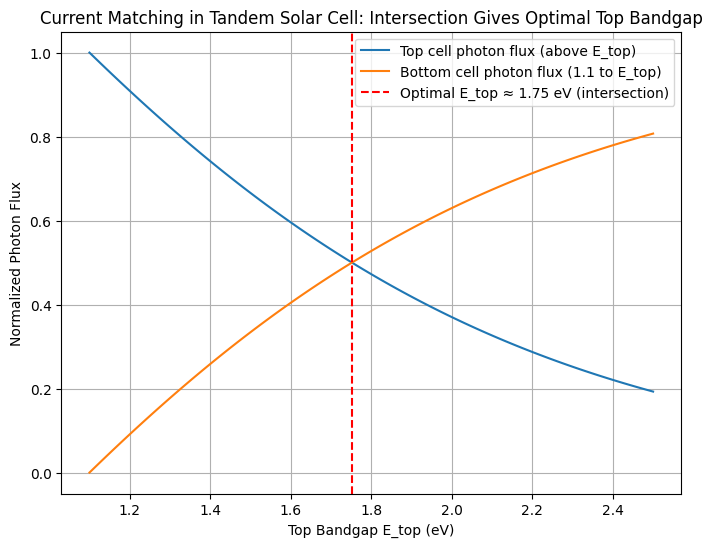

Optimal top bandgap for current matching: 1.75 eV


In [7]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Constants
k = 8.617e-5  # Boltzmann constant in eV/K
Ts = 5800     # Sun temperature for blackbody approximation (adjust to 6000 for hotter spectrum)
kTs = k * Ts  # in eV
E_bottom = 1.1  # Si bandgap in eV

# Integrand for radiative integral (photon flux proxy)
def integrand(u):
    return u**2 / (np.exp(u) - 1 + np.finfo(float).eps)  # Avoid division by zero

# Integral from x_min to inf
def int_rad(x_min):
    res, _ = quad(integrand, x_min, np.inf)
    return res

# Normalized photon flux above Eg (proportional to J_sc)
def photon_flux(Eg):
    return int_rad(Eg / kTs)

# Total photon flux above Si bandgap
flux_si = photon_flux(E_bottom)

# Function to solve for optimal E_top where top flux = bottom flux (i.e., = flux_si / 2)
def func(E_top):
    return photon_flux(E_top) - 0.5 * flux_si

# Compute optimal E_top
E_opt = fsolve(func, 1.5)[0]  # Initial guess 1.5 eV

# For plotting: Sweep E_top values
E_tops = np.linspace(1.1, 2.5, 100)
flux_top = [photon_flux(E) for E in E_tops]
flux_bottom = [flux_si - f for f in flux_top]

# Normalize for intuition (to max flux_si)
flux_top_norm = np.array(flux_top) / flux_si
flux_bottom_norm = np.array(flux_bottom) / flux_si

# Plot
plt.figure(figsize=(8, 6))
plt.plot(E_tops, flux_top_norm, label='Top cell photon flux (above E_top)')
plt.plot(E_tops, flux_bottom_norm, label='Bottom cell photon flux (1.1 to E_top)')
plt.axvline(E_opt, color='r', linestyle='--', label=f'Optimal E_top ≈ {E_opt:.2f} eV (intersection)')
plt.xlabel('Top Bandgap E_top (eV)')
plt.ylabel('Normalized Photon Flux')
plt.title('Current Matching in Tandem Solar Cell: Intersection Gives Optimal Top Bandgap')
plt.legend()
plt.grid(True)
plt.show()

# Print optimal value
print(f"Optimal top bandgap for current matching: {E_opt:.2f} eV")

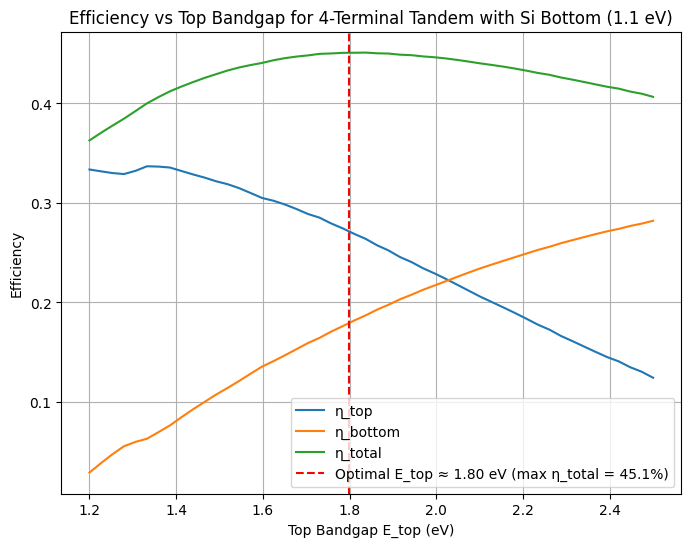

Optimal top bandgap: 1.80 eV with total efficiency 45.1%


In [8]:
#Solar spectrum data
import pandas as pd

# Load the full AM1.5G spectrum
data = pd.read_excel('AM0AM1_5.xls', skiprows=1)  # Adjust skiprows if header differs
wl_nm = data['Wavelength (nm)'].values  # Column name may vary; check with data.columns
irr = data['Global tilt  W*m-2*nm-1'].values  # Use the 'Global' column for AM1.5G; confirm name

#data = pd.read_excel('AM0AM1_5.xls', skiprows=1)
#print(data.columns)

# Then replace the photon_flux_above function with the original trapz-based version

import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

# Constants
q = 1.60217662e-19  # C
k = 1.380649e-23  # J/K
h = 6.62607015e-34  # J s
c = 2.99792458e8  # m/s
T_c = 300  # K
kT = k * T_c
hc = h * c * 1e9  # for nm to J, but for eV: hc_ev_nm = 1239.8
P_in = 1000  # W/m²

# Extended sampled AM1.5G data (wavelength nm, global irradiance W/m²/nm; approximated from standard for illustration)
#wl_nm = np.array([280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 850, 900, 950, 1000, 1050, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2200, 2400, 2600, 2800, 3000, 3500, 4000])
#irr = np.array([0.0, 0.0, 0.01, 0.05, 0.1, 0.2, 0.32, 0.5, 0.8, 1.1, 1.4, 1.6, 1.7, 1.8, 1.85, 1.88, 1.85, 1.8, 1.75, 1.7, 1.65, 1.6, 1.55, 1.5, 1.4, 1.3, 1.2, 1.05, 0.95, 0.85, 0.8, 0.75, 0.7, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.03, 0.02, 0.01, 0.0])  # Approximate values

# Convert to E_eV (descending)
E_ev = 1239.8 / wl_nm
idx = np.argsort(E_ev)[::-1]
E_ev = E_ev[idx]
wl_nm = wl_nm[idx]
irr = irr[idx]

# Photon flux Phi(λ) = irr * wl_nm / (h c in consistent units)
hc_Jnm = h * c * 1e9  # J nm
Phi = irr * wl_nm / hc_Jnm  # photons/m²/s/nm

def trapz_manual(y, x):
    return np.sum((y[:-1] + y[1:]) * 0.5 * np.diff(x))

# Function to get cumulative photon flux above Eg (integrate Phi from 0 to λ_g)
def photon_flux_above(Eg):
    λ_g = 1239.8 / Eg
    # Interp and integrate Phi from min wl to λ_g
    mask = wl_nm <= λ_g
    if not any(mask):
        return 0
    return trapz_manual(Phi[mask], wl_nm[mask])

# J0 integrand
def j0_integrand(u):
    return u**2 / (np.exp(u) - 1 + 1e-10)

# J0 for given Eg
def get_j0(Eg):
    u_g = Eg / (kT / q)  # Eg in eV, kT/q in V, but consistent
    int_val, _ = quad(j0_integrand, u_g, np.inf)
    return (2 * np.pi * q * (kT)**3 / (h**3 * c**2)) * int_val

# V_oc
def get_voc(Jsc, J0):
    if J0 == 0: return 0
    return (kT / q) * np.log(Jsc / J0 + 1)

# FF
def get_ff(Voc):
    v_oc = q * Voc / kT
    if v_oc <= 0: return 0
    return (v_oc - np.log(v_oc + 0.72)) / (v_oc + 1)

# Efficiency for a cell
def get_eta(Jsc, Eg, P_in=1000):
    J0 = get_j0(Eg)
    Voc = get_voc(Jsc, J0)
    FF = get_ff(Voc)
    return (Jsc * Voc * FF) / P_in

# Total eta for tandem
def eta_total(E_top, E_bottom=1.1):
    flux_top = photon_flux_above(E_top)
    flux_bottom = photon_flux_above(E_bottom) - flux_top
    Jsc_top = q * flux_top
    Jsc_bottom = q * flux_bottom
    eta_top = get_eta(Jsc_top, E_top)
    eta_bottom = get_eta(Jsc_bottom, E_bottom)
    return -(eta_top + eta_bottom)  # Negative for minimization

# Sweep E_tops
E_tops = np.linspace(1.2, 2.5, 50)
etas_top = []
etas_bottom = []
etas_total = []
for E_top in E_tops:
    flux_top = photon_flux_above(E_top)
    flux_bottom = photon_flux_above(1.1) - flux_top
    Jsc_top = q * flux_top
    Jsc_bottom = q * flux_bottom
    eta_top = get_eta(Jsc_top, E_top)
    eta_bottom = get_eta(Jsc_bottom, 1.1)
    etas_top.append(eta_top)
    etas_bottom.append(eta_bottom)
    etas_total.append(eta_top + eta_bottom)

# Find optimal
E_opt_res = minimize_scalar(eta_total, bounds=(1.2, 2.5), method='bounded')
E_opt = E_opt_res.x
eta_max = -E_opt_res.fun

# Plot
plt.figure(figsize= (8, 6))
plt.plot(E_tops, etas_top, label='η_top')
plt.plot(E_tops, etas_bottom, label='η_bottom')
plt.plot(E_tops, etas_total, label='η_total')
plt.axvline(E_opt, color='r', linestyle='--', label=f'Optimal E_top ≈ {E_opt:.2f} eV (max η_total = {eta_max*100:.1f}%)')
plt.xlabel('Top Bandgap E_top (eV)')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Top Bandgap for 4-Terminal Tandem with Si Bottom (1.1 eV)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal top bandgap: {E_opt:.2f} eV with total efficiency {eta_max*100:.1f}%")

Polynomial degree: 0
Error: 0.3214960170351912
Bias^2: 0.3123314713548606
Var: 0.009164545680330616
0.3214960170351912 >= 0.3123314713548606 + 0.009164545680330616 = 0.3214960170351912
Polynomial degree: 1
Error: 0.08426840630693411
Bias^2: 0.0796891867672603
Var: 0.004579219539673833
0.08426840630693411 >= 0.0796891867672603 + 0.004579219539673833 = 0.08426840630693413
Polynomial degree: 2
Error: 0.10398646080125032
Bias^2: 0.10077114273548984
Var: 0.003215318065760509
0.10398646080125032 >= 0.10077114273548984 + 0.003215318065760509 = 0.10398646080125035
Polynomial degree: 3
Error: 0.06547790180152355
Bias^2: 0.06208238634231946
Var: 0.003395515459204095
0.06547790180152355 >= 0.06208238634231946 + 0.003395515459204095 = 0.06547790180152356
Polynomial degree: 4
Error: 0.06844519414009442
Bias^2: 0.0645357900672832
Var: 0.003909404072811212
0.06844519414009442 >= 0.0645357900672832 + 0.003909404072811212 = 0.06844519414009441
Polynomial degree: 5
Error: 0.05227921801205696
Bias^2: 0.0

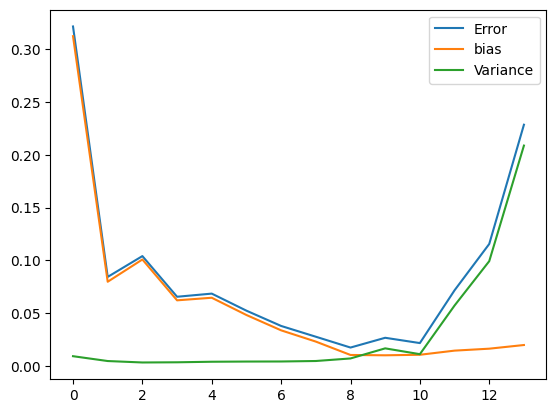

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)

n = 40
n_boostraps = 100
maxdegree = 14


# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for degree in range(maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()